# Intro to Geospatial Data using Python

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Reading the Data
The geopandas library can read almost any vector-based spatial data format including ESRI shapefile and GeoJSON files.
<br>
**NOTE:** This might take some time.

In [2]:
import geopandas as gpd

hennepin = gpd.read_file('data/MetroGIS_Tax_Parcels_2014/Parcels2014Hennepin.dbf')
hennepin.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 427762 entries, 0 to 427761
Data columns (total 70 columns):
Shape_Leng    427762 non-null float64
COUNTY_ID     427762 non-null object
PIN           427762 non-null object
BLDG_NUM      427762 non-null object
PREFIX_DIR    0 non-null object
PREFIXTYPE    0 non-null object
STREETNAME    427762 non-null object
STREETTYPE    0 non-null object
SUFFIX_DIR    0 non-null object
UNIT_INFO     51470 non-null object
CITY          427762 non-null object
CITY_USPS     414475 non-null object
ZIP           427762 non-null object
ZIP4          0 non-null object
PLAT_NAME     426333 non-null object
BLOCK         305269 non-null object
LOT           290705 non-null object
ACRES_POLY    427762 non-null float64
ACRES_DEED    427762 non-null float64
USE1_DESC     426337 non-null object
USE2_DESC     4398 non-null object
USE3_DESC     752 non-null object
USE4_DESC     207 non-null object
MULTI_USES    0 non-null object
LANDMARK      0 non-null obje

## Exploring Data
The dataset is using lots of memory. Let's check to make sure that all of the PIN values are unique and let's make sure to count NULL values in that list.

In [3]:
hennepin['PIN'].nunique(dropna=True) / len(hennepin['PIN'])

1.0

They are all unique. Now set the index so that we can traverse faster.

In [4]:
hennepin = hennepin.set_index(['PIN']).sort_index()

Now let us try to reduce memory usage by the data.

A lot of the fields are ``object`` type, which defaults to ``str`` on import. ``str`` is a not efficient, it contains a ton of additional methods like ``len()``, ``replace()``, etc. Additionally, they take up more space in memory as noted above.

Let's find how many object columns there are.

In [5]:
column_list = list(hennepin.select_dtypes(include=['object']).columns.values)
len(column_list)

54

I don't really want to go through each of the 54 columns so let's create a function that looks for columns where the number of unique values is less than 20% of the total row count. Data that has this property is said to have 'low cardinality'.

If we find a column that has low cardinality, let's convert them to ``category`` type.

In [6]:
def convert_to_categorical(df, cols):
    for col in cols:
        unique_vals = len(df[col].unique())
        unique_ratio = unique_vals / len(df)
        if unique_ratio <= 0.2:
            df[col] = df[col].astype('category')
    return df

In [7]:
hennepin = convert_to_categorical(hennepin, column_list)

TypeError: unhashable type: 'Polygon'

In [8]:
hennepin.head()

,Shape_Leng,COUNTY_ID,BLDG_NUM,PREFIX_DIR,PREFIXTYPE,STREETNAME,STREETTYPE,SUFFIX_DIR,UNIT_INFO,CITY,...,GREEN_ACRE,OPEN_SPACE,AG_PRESERV,AGPRE_ENRD,AGPRE_EXPD,PARC_CODE,TORRENS,Shape_Le_1,Shape_Area,geometry
PIN,,,,,,,,,,,,,,,,,,,,,
053-0102724110003,1298.619232,053,2901,NaN,NaN,78TH ST E,NaN,NaN,NaN,BLOOMINGTON,...,N,N,N,NaN,NaN,0,T,395.645416,7416.662441,"POLYGON ((481758.6119 4967622.9012, 481758.294..."
053-0102724110004,1388.057469,053,7800,NaN,NaN,METRO PKWY,NaN,NaN,NaN,BLOOMINGTON,...,N,N,N,NaN,NaN,0,T,422.894044,7676.706709,"POLYGON ((481827.7642 4967621.7611, 481887.776..."
053-0102724110005,1400.082610,053,7850,NaN,NaN,METRO PKWY,NaN,NaN,NaN,BLOOMINGTON,...,N,N,N,NaN,NaN,0,B,426.557685,6399.614332,"POLYGON ((481827.4471 4967582.1543, 481827.105..."
053-0102724110006,1383.510634,053,2950,NaN,NaN,METRO DR,NaN,NaN,NaN,BLOOMINGTON,...,N,N,N,NaN,NaN,0,B,421.502025,7184.857320,"POLYGON ((481799.116 4967582.6214, 481798.5232..."
053-0102724110008,1388.369487,053,7801,NaN,NaN,METRO PKWY,NaN,NaN,NaN,BLOOMINGTON,...,N,N,N,NaN,NaN,0,T,422.989308,7681.696608,"POLYGON ((482035.2701 4967618.3399, 482035.265..."


``convert_to_categorical()`` failed at ``geometry`` column. Let's try again without this column.

In [9]:
column_list = list(hennepin.select_dtypes(include=['object']).columns.values)
column_list.remove('geometry')
hennepin = convert_to_categorical(hennepin, column_list)

In [10]:
hennepin.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 427762 entries, 053-0102724110003 to 053-3612123410019
Data columns (total 69 columns):
Shape_Leng    427762 non-null float64
COUNTY_ID     427762 non-null category
BLDG_NUM      427762 non-null category
PREFIX_DIR    0 non-null category
PREFIXTYPE    0 non-null category
STREETNAME    427762 non-null category
STREETTYPE    0 non-null category
SUFFIX_DIR    0 non-null category
UNIT_INFO     51470 non-null category
CITY          427762 non-null category
CITY_USPS     414475 non-null category
ZIP           427762 non-null category
ZIP4          0 non-null category
PLAT_NAME     426333 non-null category
BLOCK         305269 non-null category
LOT           290705 non-null category
ACRES_POLY    427762 non-null float64
ACRES_DEED    427762 non-null float64
USE1_DESC     426337 non-null category
USE2_DESC     4398 non-null category
USE3_DESC     752 non-null category
USE4_DESC     207 non-null category
MULTI_USES    0 non-null category
LAND

That more than halved our memory consumption!

## Profiling

Let's get some summary stats on our data. This takes time to run but gives great amount of summary than ``describe()``.

In [ ]:
import pandas_profiling
pandas_profiling.ProfileReport(hennepin.select_dtypes(exclude=['object']))

No point in keeping constant columns in the data. Let's remove them.

In [31]:
drop_cols = ['AGPRE_ENRD', 'AGPRE_EXPD', 'COUNTY_ID', 'DWELL_TYPE', 'LANDMARK', 'MULTI_USES', 
             'NUM_UNITS', 'OWNER_MORE', 'OWN_ADD_L1', 'OWN_ADD_L2', 'OWN_ADD_L3', 'PARC_CODE', 
             'PREFIXTYPE', 'PREFIX_DIR', 'STREETTYPE', 'SUFFIX_DIR', 'ZIP4']
hennepin = hennepin.drop(drop_cols, axis=1)

## Missing Data

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


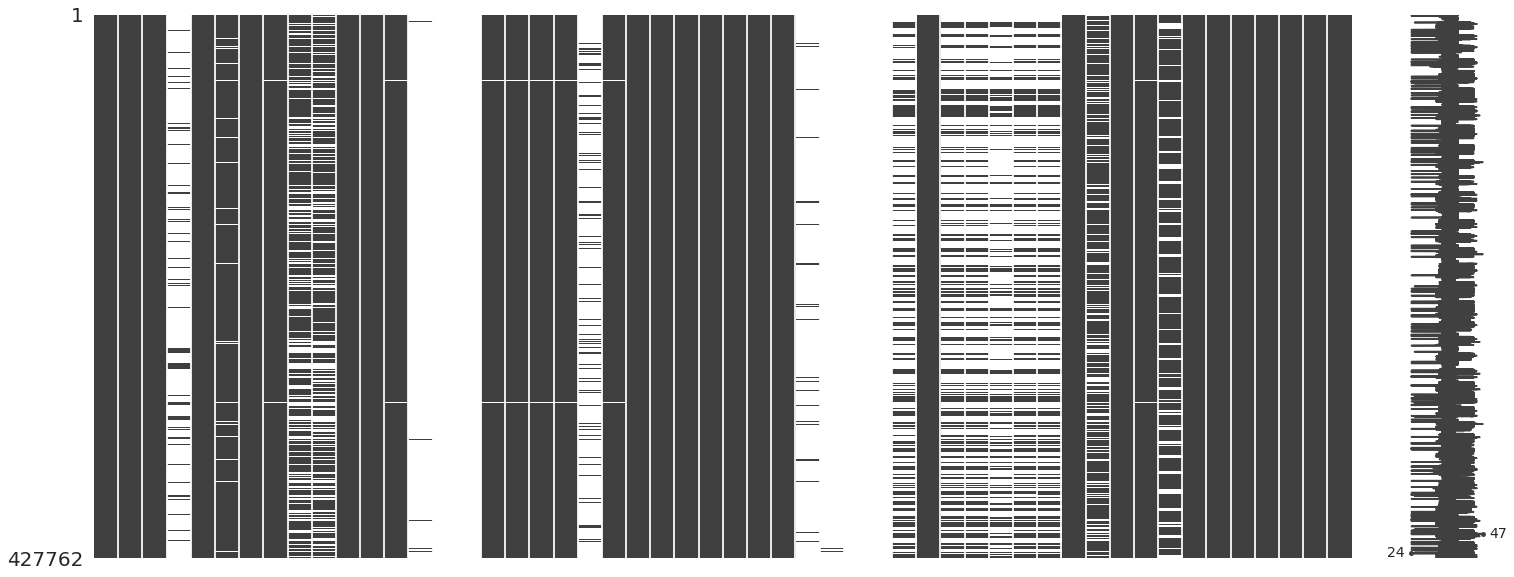

In [32]:
import missingno as msno

msno.matrix(hennepin)

Some columns are barely populated. Let's remove them if they are less than 1% populated.

In [33]:
def delete_near_null(df, cols, populated_threshold=0.01):
    for col in cols:
        non_null_rows = df[col].count()
        total_rows = len(df[col])
        populated_ratio = non_null_rows/total_rows
        if populated_ratio <= populated_threshold:
            del df[col]
    return df

In [34]:
column_list = list(hennepin.columns.values)
column_list.remove('geometry')
hennepin = delete_near_null(hennepin, column_list)

In [35]:
hennepin.shape

(427762, 47)

## Filtering on Geodesic features

The dataset may have ``Point`` information.

These are sometimes there to help break up condos into individually owned units and tax each seperately. For ease of use and sanity I'm going to exclude them.

You can also have the following ``geom_types``:
* Points / Multi-Points
* Lines / Multi-Lines
* Polygons / Multi-Polygons

In [36]:
# filter out points
hennepin = hennepin[hennepin['geometry'].geom_type != 'Point']

Geospatial Joins and Searchs are computationally expensive. For this example we will just do Minneapolis.

In [37]:
mnpls = hennepin[hennepin['CITY'] == 'MINNEAPOLIS']

In [38]:
mnpls.shape

(129889, 47)

## Joins / Merges

Enough about taxes. Let's find properties that are adjacent to Lake Calhoun.

In [39]:
water_df = gpd.read_file('data/MetCouncil_Lakes_Rivers/LakesAndRivers.dbf')
water_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2349 entries, 0 to 2348
Data columns (total 8 columns):
OWF_ID        2349 non-null object
SYSTEM        2349 non-null object
NAME_DNR      1588 non-null object
ALT_NAME      210 non-null object
AREA_ACRES    2349 non-null float64
Shape_Leng    2349 non-null float64
Shape_Area    2349 non-null float64
geometry      2349 non-null object
dtypes: float64(3), object(5)
memory usage: 146.9+ KB


In [40]:
water_df = water_df.set_index(['OWF_ID']).sort_index()

In [45]:
water_df.head()

,SYSTEM,NAME_DNR,ALT_NAME,AREA_ACRES,Shape_Leng,Shape_Area,geometry
OWF_ID,,,,,,,
00640874,River,Cannon,None,204.46,34550.497076,8.274303e+05,"(POLYGON ((498080.5626 4929447.0001, 498082.81..."
00642502,River,Crow,None,635.34,86495.867681,2.571158e+06,"POLYGON ((459093.9851 5010349.1364, 459072.415..."
00650382,River,Rum,None,584.84,96658.937378,2.366772e+06,"POLYGON ((472923.7152 5028935.1169, 472890.377..."
00653634,River,Vermillion,None,187.54,34952.857884,7.589779e+05,"POLYGON ((513795.2538 4953642.1244, 513800.514..."
00659759,River,Minnesota,None,2756.98,238410.042647,1.115714e+07,"POLYGON ((488199.715 4971431.8796, 488193.7225..."


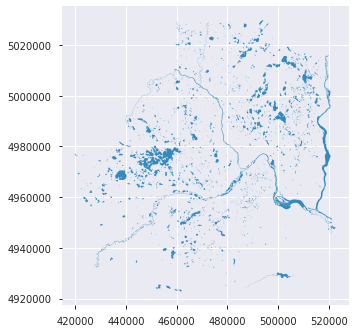

In [46]:
water_df.plot()
plt.show()

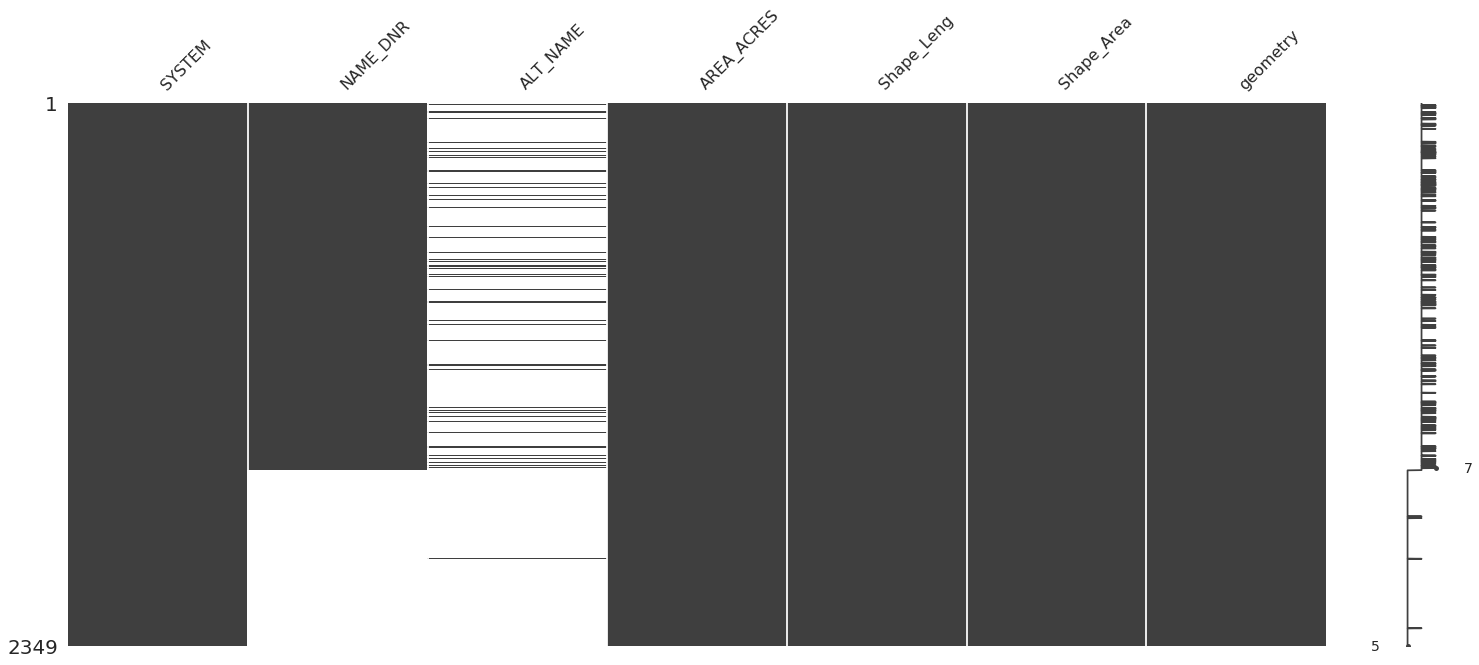

In [47]:
msno.matrix(water_df)

## Geospatial Transformations
Since geospatial calculations are computationally expensive, let's limit our data to Cedar Lake.

In [49]:
cedar_lake = water_df[water_df['NAME_DNR'] == 'Cedar']
cedar_lake

,SYSTEM,NAME_DNR,ALT_NAME,AREA_ACRES,Shape_Leng,Shape_Area,geometry
OWF_ID,,,,,,,
27003900,Lake,Cedar,None,168.41,4803.870607,6.815421e+05,"POLYGON ((474663.9454 4979190.5593, 474684.879..."
70009100,Lake,Cedar,None,793.48,11307.426102,3.211136e+06,"POLYGON ((458834.4773 4938960.6654, 458842.693..."


There are two lakes named Cedar in the dataset. Let's look at a given lake's shape to see if it's what we are expecting.

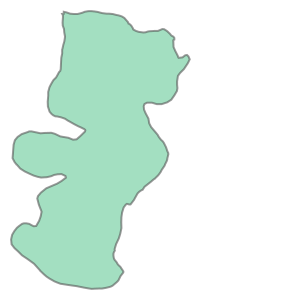

In [50]:
cedar_lake['geometry'].iloc[0]

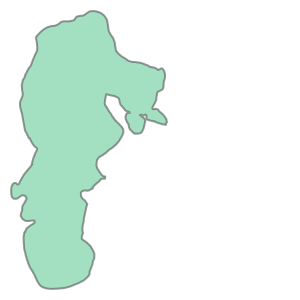

In [51]:
cedar_lake['geometry'].iloc[1]

Let's filter our set to use the first lake.

In [52]:
cedar_lake = cedar_lake.iloc[[0]]
cedar_lake

,SYSTEM,NAME_DNR,ALT_NAME,AREA_ACRES,Shape_Leng,Shape_Area,geometry
OWF_ID,,,,,,,
27003900,Lake,Cedar,None,168.41,4803.870607,681542.105331,"POLYGON ((474663.9454 4979190.5593, 474684.879..."


If we want to get properties next to Cedar Lake, we would want to know that around many lakes in the city there is a public trail, so we need to expand our search beyond just what touches the lake.

We can accomplish this by ``buffering`` or making the shape bigger in all directions. Let's do 100m for good measure.

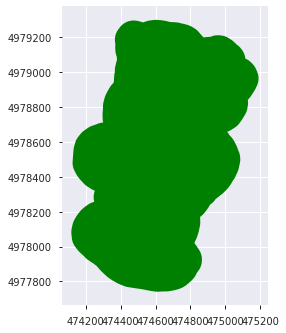

In [53]:
buffered_cedar_lake = cedar_lake.buffer(100)
ax = cedar_lake.plot(color='red')

buffered_cedar_lake.plot(ax=ax, color='green')
plt.show()

For now we don't really care about any of the other attributes attached to this lake, we just care about its shape, so let's just get the ``Polygon`` to see where their are overlaps with properties.

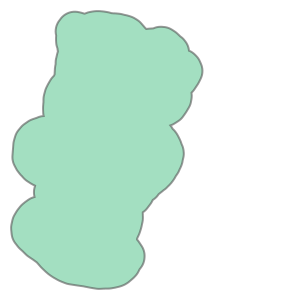

In [56]:
buffered_cedar_poly = buffered_cedar_lake.iloc[0]
buffered_cedar_poly

Quickly narrow down search using ``rtree`` library.

First step is to set the spatial index of the geospatial dataset we wish to search

In [57]:
spatial_index = mnpls.sindex

Filter out a vast majority by seeing if a point is inside a rectangle.

A Bounding Box makes the smallest possible rectangle that completely encloses our polygon.

It is just a tuple of minx, miny, maxx, maxy.

In [58]:
cedar_bb = buffered_cedar_poly.bounds
cedar_bb

(474116.7938611487, 4977740.731593291, 475191.1664816106, 4979300.6081)

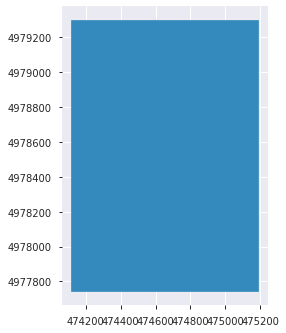

In [60]:
from shapely.geometry import box
from descartes import PolygonPatch

# convert the bounding box tuple into a polygon
cedar_box = box(cedar_bb[0], cedar_bb[1], cedar_bb[2], cedar_bb[3])

# plot the rectangle
fig = plt.figure() 
ax = fig.gca() 
ax.add_patch(PolygonPatch(cedar_box))

# ensure we aren't distorting the image
ax.axis('scaled')

# plot the buffered cedar lake polygon on top
buffered_cedar_lake.plot(ax=ax)
plt.show()

Now we find all of the index values of the Minneapolis Tax Parcels that intersect with this bounding box.

In [61]:
possible_matches_index = list(spatial_index.intersection(cedar_bb))

Now we can select those parcels by their index values

In [63]:
possible_matches = mnpls.iloc[possible_matches_index]
possible_matches.shape

(457, 47)

This was fairly quick and we have gone from 100k+ records down to a handful.

Next we look at those that actually touch that 100m buffer around Cedar Lake.

In [64]:
precise_matches = possible_matches[possible_matches.intersects(buffered_cedar_poly)]
precise_matches.shape

(208, 47)

We are left with 208 parcels that are within 100m of Cedar Lake.

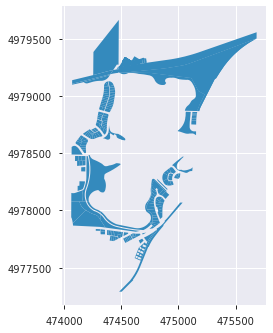

In [65]:
precise_matches.plot()
plt.show()

Let's make a new dataframe that is only these matches. Let's add a column specifies these are close to Cedar Lake.

In [66]:
cedar_lake_parcels = precise_matches.copy()
cedar_lake_parcels['LAKE_NAME'] = 'Cedar Lake'

## Joining Tabular Data to Geospatial Data

Now let's append some Lake Quality to these parcels surrounding Cedar Lake.

In [67]:
lake_qual = pd.read_csv('data/MN_PCA_Cedar_Lake/cedar_lake_qual.csv',
                        parse_dates=['sampleDate', 'analysisDate'],
                        na_values='(null)')
lake_qual.head()

,analysisDate,collectingOrg,comments,county,gtlt,parameter,result,resultUnit,sampleDate,sampleTime,sampleDepthUnit,sampleFractionType,sampleLowerDepth,sampleType,sampleUpperDepth,stationId,stationName,statisticType,testMethodId,testMethodName
0,1901-01-01,MPCA Lake Monitoring Program Project,NaN,Hennepin,NaN,"Chlorophyll a, uncorrected for pheophytin",8.79,ug/L,1971-06-08,00:01:00,m,Total,NaN,Sample,0.0,27-0039-00-202,CEDAR,NaN,LEG_P32210,CHLOROPHYLL-A UG/L TRICHROMATIC UNCORRECTED
1,1901-01-01,MPCA Lake Monitoring Program Project,NaN,Hennepin,NaN,"Chlorophyll a, uncorrected for pheophytin",3.88,ug/L,1972-07-12,00:01:00,m,Total,NaN,Sample,0.0,27-0039-00-202,CEDAR,NaN,LEG_P32210,CHLOROPHYLL-A UG/L TRICHROMATIC UNCORRECTED
2,1901-01-01,MPCA Lake Monitoring Program Project,NaN,Hennepin,NaN,"Chlorophyll a, uncorrected for pheophytin",13.7,ug/L,1972-07-24,00:01:00,m,Total,NaN,Sample,0.0,27-0039-00-202,CEDAR,NaN,LEG_P32210,CHLOROPHYLL-A UG/L TRICHROMATIC UNCORRECTED
3,1901-01-01,MPCA Lake Monitoring Program Project,NaN,Hennepin,NaN,"Chlorophyll a, uncorrected for pheophytin",18.76,ug/L,1972-08-09,00:01:00,m,Total,NaN,Sample,0.0,27-0039-00-202,CEDAR,NaN,LEG_P32210,CHLOROPHYLL-A UG/L TRICHROMATIC UNCORRECTED
4,1901-01-01,MPCA Lake Monitoring Program Project,NaN,Hennepin,NaN,"Chlorophyll a, uncorrected for pheophytin",17.16,ug/L,1972-08-18,00:01:00,m,Total,NaN,Sample,0.0,27-0039-00-202,CEDAR,NaN,LEG_P32210,CHLOROPHYLL-A UG/L TRICHROMATIC UNCORRECTED


In [68]:
lake_qual.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29531 entries, 0 to 29530
Data columns (total 20 columns):
analysisDate          29531 non-null datetime64[ns]
collectingOrg         29531 non-null object
comments              56 non-null object
county                29531 non-null object
gtlt                  1035 non-null object
parameter             29531 non-null object
result                29443 non-null object
resultUnit            29393 non-null object
sampleDate            29531 non-null datetime64[ns]
sampleTime            29531 non-null object
sampleDepthUnit       29531 non-null object
sampleFractionType    29531 non-null object
sampleLowerDepth      2525 non-null float64
sampleType            29531 non-null object
sampleUpperDepth      29523 non-null float64
stationId             29531 non-null object
stationName           29531 non-null object
statisticType         1 non-null object
testMethodId          29531 non-null object
testMethodName        29531 non-null object
dt

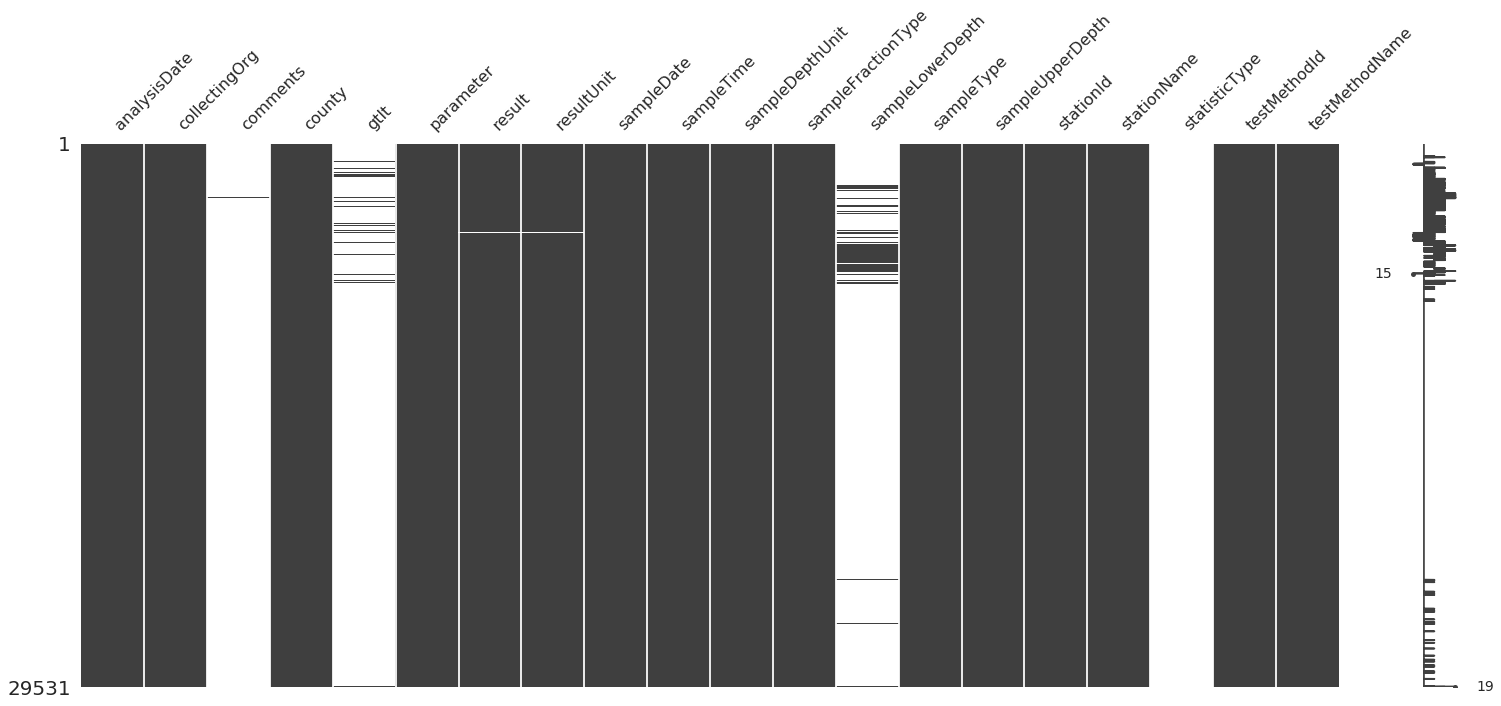

In [69]:
msno.matrix(lake_qual)

In [70]:
pandas_profiling.ProfileReport(lake_qual)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


Can't figure out why result is being treated as a categorical variable.

In [71]:
lake_qual['result'] = lake_qual['result'].astype('float')

ValueError: could not convert string to float: '3.FAIR'

We need to replace '3.FAIR' with '3'.

In [74]:
lake_qual['result'] = lake_qual['result'].astype('str').replace('3.FAIR', '3')

In [75]:
lake_qual['result'] = lake_qual['result'].astype('float')

ValueError: could not convert string to float: '3.MED ALGAE'

We need to replace '3.MED ALGAE' with '3'.

In [76]:
lake_qual['result'] = lake_qual['result'].astype('str').replace('3.MED ALGAE', '3')

In [78]:
lake_qual['result'] = lake_qual['result'].astype('float')

Let us filter down our data to 2014.

In [79]:
lake_qual = lake_qual[lake_qual['sampleDate'].dt.year == 2014]
lake_qual.shape

(984, 20)

In [80]:
lake_qual.head()

,analysisDate,collectingOrg,comments,county,gtlt,parameter,result,resultUnit,sampleDate,sampleTime,sampleDepthUnit,sampleFractionType,sampleLowerDepth,sampleType,sampleUpperDepth,stationId,stationName,statisticType,testMethodId,testMethodName
2803,1901-01-01,Minneapolis Chain of Lakes Project,NaN,Hennepin,NaN,Phosphorus as P,0.022,mg/L,2014-06-25,12:24:00,m,Total,NaN,Sample,5.0,27-0039-00-202,CEDAR,NaN,4500-P-E,Phosphorus in Water by Colorimetry- Ascorbic A...
2804,1901-01-01,Minneapolis Chain of Lakes Project,Lab qualifier: (<),Hennepin,<,Orthophosphate as P,0.003,mg/L,2014-06-25,12:24:00,m,Dissolved,NaN,Sample,5.0,27-0039-00-202,CEDAR,NaN,4500-P-E,Phosphorus in Water by Colorimetry- Ascorbic A...
2805,1901-01-01,Minneapolis Chain of Lakes Project,NaN,Hennepin,NaN,Phosphorus as P,0.058,mg/L,2014-06-25,12:21:00,m,Total,NaN,Sample,10.0,27-0039-00-202,CEDAR,NaN,4500-P-E,Phosphorus in Water by Colorimetry- Ascorbic A...
2806,1901-01-01,Minneapolis Chain of Lakes Project,NaN,Hennepin,NaN,Orthophosphate as P,0.024,mg/L,2014-06-25,12:21:00,m,Dissolved,NaN,Sample,10.0,27-0039-00-202,CEDAR,NaN,4500-P-E,Phosphorus in Water by Colorimetry- Ascorbic A...
2807,1901-01-01,Minneapolis Chain of Lakes Project,NaN,Hennepin,NaN,Phosphorus as P,0.111,mg/L,2014-06-25,12:20:00,m,Total,NaN,Sample,14.0,27-0039-00-202,CEDAR,NaN,4500-P-E,Phosphorus in Water by Colorimetry- Ascorbic A...


Looks like the data needs to be pivoted out.

In [81]:
lake_qual_pivot = lake_qual.pivot_table(values='result', index='sampleDate', columns='parameter')
lake_qual_pivot.head()

parameter,"Alkalinity, total as CaCO3",Chloride,"Chlorophyll a, corrected for pheophytin","Depth, Secchi disk depth",Dissolved oxygen (DO),"Hardness, carbonate as CaCO3",Inorganic nitrogen (nitrate and nitrite) as N,Kjeldahl nitrogen as N,Nutrient-nitrogen as N,Orthophosphate as P,Pheophytin a,Phosphorus as P,Silica as SiO2,Specific conductance,Sulfate as SO4,"Temperature, water",pH
sampleDate,,,,,,,,,,,,,,,,,
2014-03-12,134.0,133.5,0.50,NaN,2.215333,164.0,0.577,1.37,0.792,0.03850,0.50,0.17100,1.28,750.846667,NaN,2.940000,7.206667
2014-05-05,122.0,162.0,5.47,1.41,7.363529,152.0,0.144,1.00,1.180,0.00950,5.10,0.05725,0.50,691.841176,8.8,6.543529,7.844706
2014-05-20,NaN,140.5,3.30,1.10,6.518125,NaN,NaN,NaN,0.964,0.00525,1.23,0.05425,NaN,711.987500,NaN,8.570000,7.993125
2014-06-11,NaN,141.5,2.40,3.85,3.059412,NaN,NaN,NaN,0.855,0.01500,0.50,0.05200,0.50,717.082353,NaN,10.798235,7.157647
2014-06-25,NaN,118.0,8.20,2.17,3.078235,NaN,NaN,NaN,0.657,0.01925,0.83,0.05475,NaN,696.905882,NaN,11.915294,7.592353


I would like to add lat/long of Cedar Lake in the data.

In [83]:
lake_qual_pivot['latitude'] = 44.961482
lake_qual_pivot['longitude'] = -93.32013

In [84]:
lake_qual_pivot['LAKE_NAME'] = 'Cedar Lake'

In [85]:
result = cedar_lake_parcels.reset_index().merge(lake_qual_pivot, on='LAKE_NAME')
result.head()

,PIN,Shape_Leng,BLDG_NUM,STREETNAME,UNIT_INFO,CITY,CITY_USPS,ZIP,PLAT_NAME,BLOCK,LOT,ACRES_POLY,ACRES_DEED,USE1_DESC,USE2_DESC,OWNER_NAME,TAX_NAME,TAX_ADD_L1,TAX_ADD_L2,TAX_ADD_L3,HOMESTEAD,EMV_LAND,EMV_BLDG,EMV_TOTAL,TAX_CAPAC,TOTAL_TAX,SPEC_ASSES,TAX_EXEMPT,XUSE1_DESC,HOME_STYLE,FIN_SQ_FT,GARAGE,GARAGESQFT,BASEMENT,HEATING,COOLING,YEAR_BUILT,SALE_DATE,SALE_VALUE,SCHOOL_DST,WSHD_DIST,GREEN_ACRE,OPEN_SPACE,AG_PRESERV,TORRENS,Shape_Le_1,Shape_Area,geometry,LAKE_NAME,"Alkalinity, total as CaCO3",Chloride,"Chlorophyll a, corrected for pheophytin","Depth, Secchi disk depth",Dissolved oxygen (DO),"Hardness, carbonate as CaCO3",Inorganic nitrogen (nitrate and nitrite) as N,Kjeldahl nitrogen as N,Nutrient-nitrogen as N,Orthophosphate as P,Pheophytin a,Phosphorus as P,Silica as SiO2,Specific conductance,Sulfate as SO4,"Temperature, water",pH,latitude,longitude
0,053-2902924330011,386.023041,1944,CEDAR LAKE PKWY,NaN,MINNEAPOLIS,MINNEAPOLIS,55416,MCNAIR PARK,003,010,0.15,0.0,Residential,NaN,TIMOTHY RAY MCCOY,TIMOTHY RAY MCCOY,1944 CEDAR LAKE PKWY,MPLS MN 55416,NaN,Y,276700.0,265300.0,542000.0,5525.0,9848.0,0.0,N,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1911,1985-08-01,114000.0,001,Minnehaha Creek,N,N,N,A,117.609048,619.160054,"POLYGON ((474397.3278 4978993.221, 474398.2754...",Cedar Lake,134.0,133.5,0.50,NaN,2.215333,164.0,0.577,1.37,0.792,0.03850,0.50,0.17100,1.28,750.846667,NaN,2.940000,7.206667,44.961482,-93.32013
1,053-2902924330011,386.023041,1944,CEDAR LAKE PKWY,NaN,MINNEAPOLIS,MINNEAPOLIS,55416,MCNAIR PARK,003,010,0.15,0.0,Residential,NaN,TIMOTHY RAY MCCOY,TIMOTHY RAY MCCOY,1944 CEDAR LAKE PKWY,MPLS MN 55416,NaN,Y,276700.0,265300.0,542000.0,5525.0,9848.0,0.0,N,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1911,1985-08-01,114000.0,001,Minnehaha Creek,N,N,N,A,117.609048,619.160054,"POLYGON ((474397.3278 4978993.221, 474398.2754...",Cedar Lake,122.0,162.0,5.47,1.41,7.363529,152.0,0.144,1.00,1.180,0.00950,5.10,0.05725,0.50,691.841176,8.8,6.543529,7.844706,44.961482,-93.32013
2,053-2902924330011,386.023041,1944,CEDAR LAKE PKWY,NaN,MINNEAPOLIS,MINNEAPOLIS,55416,MCNAIR PARK,003,010,0.15,0.0,Residential,NaN,TIMOTHY RAY MCCOY,TIMOTHY RAY MCCOY,1944 CEDAR LAKE PKWY,MPLS MN 55416,NaN,Y,276700.0,265300.0,542000.0,5525.0,9848.0,0.0,N,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1911,1985-08-01,114000.0,001,Minnehaha Creek,N,N,N,A,117.609048,619.160054,"POLYGON ((474397.3278 4978993.221, 474398.2754...",Cedar Lake,NaN,140.5,3.30,1.10,6.518125,NaN,NaN,NaN,0.964,0.00525,1.23,0.05425,NaN,711.987500,NaN,8.570000,7.993125,44.961482,-93.32013
3,053-2902924330011,386.023041,1944,CEDAR LAKE PKWY,NaN,MINNEAPOLIS,MINNEAPOLIS,55416,MCNAIR PARK,003,010,0.15,0.0,Residential,NaN,TIMOTHY RAY MCCOY,TIMOTHY RAY MCCOY,1944 CEDAR LAKE PKWY,MPLS MN 55416,NaN,Y,276700.0,265300.0,542000.0,5525.0,9848.0,0.0,N,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1911,1985-08-01,114000.0,001,Minnehaha Creek,N,N,N,A,117.609048,619.160054,"POLYGON ((474397.3278 4978993.221, 474398.2754...",Cedar Lake,NaN,141.5,2.40,3.85,3.059412,NaN,NaN,NaN,0.855,0.01500,0.50,0.05200,0.50,717.082353,NaN,10.798235,7.157647,44.961482,-93.32013
4,053-2902924330011,386.023041,1944,CEDAR LAKE PKWY,NaN,MINNEAPOLIS,MINNEAPOLIS,55416,MCNAIR PARK,003,010,0.15,0.0,Residential,NaN,TIMOTHY RAY MCCOY,TIMOTHY RAY MCCOY,1944 CEDAR LAKE PKWY,MPLS MN 55416,NaN,Y,276700.0,265300.0,542000.0,5525.0,9848.0,0.0,N,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1911,1985-08-01,114000.0,001,Minnehaha Creek,N,N,N,A,117.609048,619.160054,"POLYGON ((474397.3278 4978993.221, 474398.2754...",Cedar Lake,NaN,118.0,8.20,2.17,3.078235,NaN,NaN,NaN,0.657,0.01925,0.83,0.05475,NaN,696.905882,NaN,11.915294,7.592353,44.961482,-93.32013


In [86]:
result.shape

(2496, 68)

In [87]:
result = result.dropna(axis=1, how='all')
result.shape

(2496, 60)

## Geospatial Calculations

Some lakes have multiple monitoring stations. Let's just do a simple calculation from the center of each parcel to the Lat/Long of the Monitoring Site.

In [89]:
result['Parcel_Centroid'] = result.centroid
result['Parcel_Centroid'].head()

0    POINT (474420.2918534343 4978995.538410055)
1    POINT (474420.2918534343 4978995.538410055)
2    POINT (474420.2918534343 4978995.538410055)
3    POINT (474420.2918534343 4978995.538410055)
4    POINT (474420.2918534343 4978995.538410055)
Name: Parcel_Centroid, dtype: object

Those don't look like any type of GPS coords I've seen.

GIS files use different 'datums' to set the origin of their coordinate systems. We will need to convert this.

This [GIS.stackexchange](http://gis.stackexchange.com/a/722) goes over the concept in detail.

In [90]:
result.crs

{'init': 'epsg:26915'}

Convert the projection to normal Lat/Long

In [92]:
result = result.to_crs({'init': 'epsg:4326'})
result['Parcel_Centroid'] = result.centroid
result['Parcel_Centroid'].head()

0    POINT (-93.324349184036 44.96393792859692)
1    POINT (-93.324349184036 44.96393792859692)
2    POINT (-93.324349184036 44.96393792859692)
3    POINT (-93.324349184036 44.96393792859692)
4    POINT (-93.324349184036 44.96393792859692)
Name: Parcel_Centroid, dtype: object

The problem here is that these centroids are still ``shapley.geometry.Point`` objects. We need to get them into tuples for ``geopy`` to work with.

In [93]:
result['Parcel_Centroid'] = result['Parcel_Centroid'].apply(lambda p: tuple([p.y, p.x]))
result['Parcel_Centroid'].head()

0    (44.96393792859692, -93.324349184036)
1    (44.96393792859692, -93.324349184036)
2    (44.96393792859692, -93.324349184036)
3    (44.96393792859692, -93.324349184036)
4    (44.96393792859692, -93.324349184036)
Name: Parcel_Centroid, dtype: object

In [94]:
from shapely.geometry import Point

result['station_coords'] = tuple(zip(result['latitude'], result['longitude']))
# remove the old columns
drop_cols = ['latitude', 'longitude']
result = result.drop(drop_cols, axis=1)

result['station_coords'].head()

0    (44.961482, -93.32013)
1    (44.961482, -93.32013)
2    (44.961482, -93.32013)
3    (44.961482, -93.32013)
4    (44.961482, -93.32013)
Name: station_coords, dtype: object

Now that we have lat/long points, we can calculate distance. The key here is to use Vincenty's formula. It calculates distance between two points on spheroid. Euclidean distance will give accurate results only on the equator.

In [95]:
from geopy.distance import geodesic

In [97]:
def calc_dist(row):
    dist_to_station = geodesic(row['Parcel_Centroid'], row['station_coords']).kilometers
    return dist_to_station

In [98]:
result['dist_to_station'] = result.apply(calc_dist, axis=1)
result['dist_to_station'].head()

0    0.430469
1    0.430469
2    0.430469
3    0.430469
4    0.430469
Name: dist_to_station, dtype: float64

Now we just want the data where its the closest to the point.

In [99]:
def get_min_rows(df, grpby, aggcol):
    min_values = df.groupby(grpby)[aggcol].transform(min)
    return df[df[aggcol] == min_values]

In [100]:
min_parcels = get_min_rows(result, 'PIN', 'dist_to_station')
min_parcels.shape

(2496, 61)

## Writing Data Out

GeoDataFrames can be exported to many different standard formats.

In [113]:
min_parcels['Parcel_Centroid'] = min_parcels['Parcel_Centroid'].astype('str')
min_parcels['station_coords'] = min_parcels['station_coords'].astype('str')

min_parcels.to_csv('result.csv', index=False)